## Tutorial 8, Question 4

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import os
if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')

creating the figures folder


## Create Training and Test Data

In [6]:
data = ['I did not like the movie',
        'The movie was not good',
        'I watched the movie with great interest',
        'I have seen better movies',
        'Good to see that movie',
        'I am not a fan of movies',
        'I liked the movie great',
        'The movie was of interest to me',
        'I thought they could show interesting scenes',
        'The movie did not have good scenes',
        'Family did not like the movie at all']

targets = [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0]

test_data = ['The movie was not interesting to me',
        'I liked the movie with great interest']

# Text Preprocessing Functions

This section introduces two functions, `vocabulary` and `preprocess`, designed to process and convert strings into a format suitable for machine learning models.

## `vocabulary` Function:

This function constructs a vocabulary from a list of strings.

1. **Parameters**:
    - `strings`: A list of strings from which the vocabulary is constructed.

2. **Functionality**:
    - All characters from the input strings are extracted, converted to lowercase, and then a set is created to remove duplicates.
    - The unique characters are sorted to create a consistent ordering.
    - A dictionary (`char_to_ix`) is created to map each character to a unique integer ID.

3. **Return**:
    - `vocab_size`: The total number of unique characters in the vocabulary.
    - `char_to_ix`: A dictionary mapping each character to its unique integer ID.

## `preprocess` Function:

This function converts a list of strings into a tensor of integer IDs based on a given character-to-ID mapping.

1. **Parameters**:
    - `strings`: A list of strings to be preprocessed.
    - `char_to_ix`: A dictionary mapping characters to their unique integer IDs.

2. **Functionality**:
    - Each string in the input list is converted to lowercase.
    - Strings are truncated or padded to match the `MAX_LENGTH`:
        - If a string's length exceeds `MAX_LENGTH`, it's truncated.
        - If a string's length is less than `MAX_LENGTH`, it's padded with spaces.
    - Each character in the processed strings is then converted to its corresponding integer ID using the `char_to_ix` mapping.

3. **Return**:
    - A tensor of shape `[number of strings, MAX_LENGTH]`, where each entry represents the integer ID of a character.

By using these functions, we can easily convert raw text data into a numerical format that can be fed into machine learning models, ensuring consistent length and representation.



In [7]:
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings).lower()))))
    char_to_ix = {ch: i for i, ch in enumerate(chars)}
    vocab_size = len(chars)
    return vocab_size, char_to_ix

def preprocess(strings, char_to_ix):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d) > MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return torch.tensor(data_ids, dtype=torch.int64)

seed = 10
MAX_LENGTH = 40
MAX_LABEL = 2

np.random.seed(seed)
torch.manual_seed(seed)

# Character-Level RNN Model: `CharRNN`

The `CharRNN` class defines a simple character-level Recurrent Neural Network (RNN) using the GRU (Gated Recurrent Unit) architecture.

## Class Initialization:

### Parameters:
- `vocab_size`: The size of the vocabulary, which determines the input size to the RNN.
- `hidden_dim`: The number of hidden units in the GRU layer (default is set to 10).

### Layers:
1. **GRU Layer (`self.rnn`)**:
    - An GRU layer with `vocab_size` input features and `hidden_dim` hidden units.
    - `batch_first=True` indicates that the input tensor's first dimension will represent the batch size.
   
2. **Linear Layer (`self.dense`)**:
    - A fully connected linear layer that maps from `hidden_dim` features to `MAX_LABEL` output features, where `MAX_LABEL` represents the number of classes or labels in the classification task.

## Forward Method:

### Parameters:
- `x`: The input tensor of shape `[batch_size, sequence_length]`, where each entry is the integer ID of a character.
- `drop_rate`: The dropout rate applied to the output of the GRU layer before it is passed to the linear layer.

### Computation Steps:
1. **One-Hot Encoding**:
    - The input tensor `x` is one-hot encoded using `nn.functional.one_hot`, resulting in a tensor of shape `[batch_size, sequence_length, vocab_size]`. This provides a binary representation of each character ID.
   
2. **GRU Forward Pass**:
    - The one-hot encoded input is passed through the GRU layer. The GRU returns the output for each time step and the final hidden state. We only use the output in this implementation.

3. **Extracting the Last Output**:
    - The output from the last time step (`encoding[:, -1, :]`) is extracted to be used as the representation of the entire sequence.

4. **Dropout**:
    - Dropout is applied to the extracted output to prevent overfitting during training. The dropout rate is specified by `drop_rate`.

5. **Linear Layer**:
    - The dropout-treated output is passed through the linear layer to produce the final output logits.

6. **Return**:
    - The logits are returned, which can be used with a suitable loss function (like CrossEntropyLoss) for classification tasks.

This `CharRNN` model is designed to handle sequence classification tasks where the input is a sequence of character IDs and the output is a classification label.



In [8]:
class CharRNN(nn.Module):

    def __init__(self, vocab_size, hidden_dim=10):
        super(CharRNN, self).__init__()
        self.rnn = nn.GRU(vocab_size, hidden_dim, batch_first=True)
        self.dense = nn.Linear(hidden_dim, MAX_LABEL)

    def forward(self, x, drop_rate):
        byte_vectors = nn.functional.one_hot(x, num_classes=vocab_size).float()
        encoding, _ = self.rnn(byte_vectors)
        encoding = encoding[:, -1, :]
        encoding = nn.functional.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
        return logits

In [9]:
vocab_size, char_to_ix = vocabulary(data)
x_train = preprocess(data, char_to_ix)
y_train = torch.tensor(targets, dtype=torch.int64)
x_test = preprocess(test_data, char_to_ix)

model = CharRNN(vocab_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [10]:
loss, acc = [], []
no_epochs = 500
for e in range(no_epochs):
    optimizer.zero_grad()
    logits = model(x_train, drop_rate=0.3)
    loss_ = criterion(logits, y_train)
    loss_.backward()
    optimizer.step()
    acc_ = (logits.argmax(dim=1) == y_train).float().mean().item()
    loss.append(loss_.item()), acc.append(acc_)

    if e % 10 == 0:
        print(f'epoch: {e}, entropy: {loss[e]}, acc: {acc[e]}')

with torch.no_grad():
    test_logits = model(x_test, drop_rate=0)
    probs = nn.functional.softmax(test_logits, dim=1)
    print(probs)

epoch: 0, entropy: 0.7969350218772888, acc: 0.4545454680919647
epoch: 10, entropy: 0.7186139822006226, acc: 0.4545454680919647
epoch: 20, entropy: 0.6671566963195801, acc: 0.7272727489471436
epoch: 30, entropy: 0.7050613760948181, acc: 0.5454545617103577
epoch: 40, entropy: 0.6585426926612854, acc: 0.4545454680919647
epoch: 50, entropy: 0.5566622614860535, acc: 0.7272727489471436
epoch: 60, entropy: 0.658875584602356, acc: 0.6363636255264282
epoch: 70, entropy: 0.627617597579956, acc: 0.6363636255264282
epoch: 80, entropy: 0.6615921854972839, acc: 0.6363636255264282
epoch: 90, entropy: 0.6486794948577881, acc: 0.6363636255264282
epoch: 100, entropy: 0.6256358027458191, acc: 0.6363636255264282
epoch: 110, entropy: 0.5945571660995483, acc: 0.6363636255264282
epoch: 120, entropy: 0.5580364465713501, acc: 0.7272727489471436
epoch: 130, entropy: 0.6547574996948242, acc: 0.7272727489471436
epoch: 140, entropy: 0.615634024143219, acc: 0.7272727489471436
epoch: 150, entropy: 0.6440038084983826

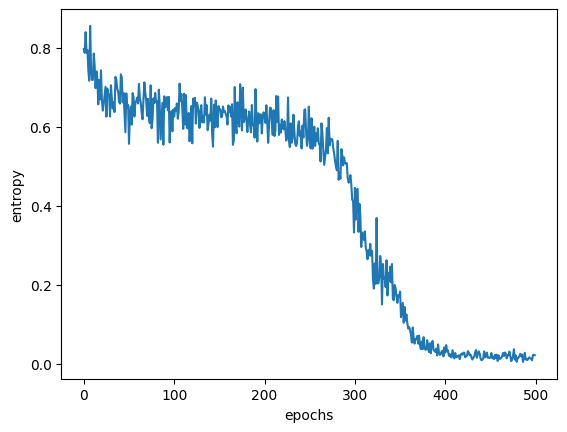

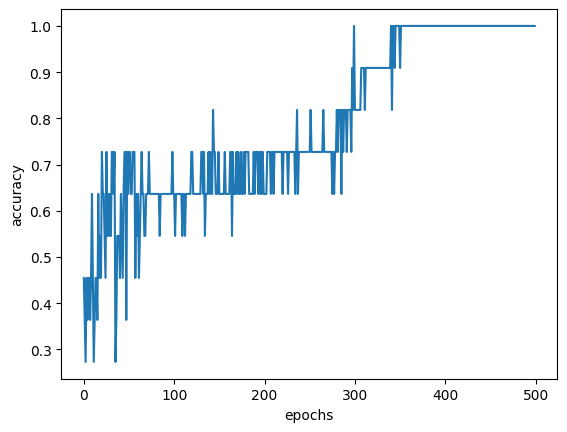

In [11]:
plt.figure()
plt.plot(range(len(loss)), loss)
plt.xlabel('epochs')
plt.ylabel('entropy')
plt.savefig('figures/t9q3_1.png')

plt.figure()
plt.plot(range(len(acc)), acc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig('figures/t9q3_2.png')

plt.show()